In [ ]:
# INSTALL EXTRA PACKAGES
!pip install -q tf-models-official
!pip install -q -U tensorflow-text


# Conda notebook

This notebook has been executed on Jupyter, using Conda. There is an issue with fetching the pre-trained model that is a known bug on Colab.

In [ ]:
# GENERAL IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import math

In [ ]:
#NN IMPORTS
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

C:\Users\andre\anaconda3\envs\env4\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\andre\anaconda3\envs\env4\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you 

In [ ]:
# DATASET

#dataset_raw_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
base_path=r"C:\Users\andre\Documents\project"
dataset_path = os.path.join(base_path, "dataset_bert1")
dataset_path_test = os.path.join(dataset_path, "test")
dataset_path_train = os.path.join(dataset_path, "train")

os.listdir(dataset_path)

['test', 'train']

# Data loading
Bert takes Datasets as input, and it's based on reading a full directory of files for each class.

We split the content in training, validation and test making separate Datasets.

In [ ]:
# Map of the expected value to their labels with id_TO_label and label_TO_id
def id_to_label(id):
  if id == 0:
    return "FAKE"
  else:
    return "HUMAN"
def label_to_id(label):
  if label in ["FAKE","Fake","fake"]:
    return 0
  else:
    return 1

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 10
seed = 42

# LOADING THE DATASET

#TRAIN PART OF THE DATASET
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    dataset_path_train,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

#VALIDATION PART OF THE DATASET
val_ds = tf.keras.utils.text_dataset_from_directory(
    dataset_path_train,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#TEST PART OF THE DATASET
test_ds = tf.keras.utils.text_dataset_from_directory(
    dataset_path_test,
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 17255 files belonging to 2 classes.
Using 13804 files for training.
Found 17255 files belonging to 2 classes.
Using 3451 files for validation.
Found 3056 files belonging to 2 classes.


In [ ]:
#SHOW EXAMPLES
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'I enjoyed Albert Pyun\'s "Nemesis" for its cheesy action and semi-complicated script. A lot of people complain about the "confusing" plot to the first film, which is probably why "Nemesis 2: Nebula" has a dumb as rocks plot with the same super-action to carry it through.<br /><br />This one gives the name of the first movie\'s hero, Alex, to a bulked up super-female sent to the past to save the future. She is raised by a tribe in Africa. A good portion of the film only has dialogue in an African tongue without subtitles, which I liked because it made it seem somewhat authentic (how often do movies in this genre really try to do that?). It doesn\'t take long for the evil cyborgs to time travel back in time to find her and try to kill her.<br /><br />Don\'t get me wrong, this is a piece of crap (not that the first one was anything great). There are subplots involving Africa\'s political unrest, treasure hunting, and tribal combat. The picture is very short on brains, so none of

# Pre-trained BERT

The library offers a huge amount of siblings. We pick the simplest one and instantiate only that one.

In [ ]:
#MAPPING MODEL NAME TO URL
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


#Preprocessing
Bert requires the input to be tokenized. The tokenizer is a different model, provided by Tensorflow's Bert libraries.


##Colab Bug

Colab is unable to access the Hub for Keras Layers, therefore making impossible to get the tokenizer. This is why we had to execute the notebook on a different environment.

In [ ]:
#CREATION OF PREPROCESSING MODEL OBJECT
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

#EXAMPLE OF PREPROCESSING
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
#CREATION OF ENCODER MODEL OBJECT
bert_model = hub.KerasLayer(tfhub_handle_encoder)

#EXAMPLE OF ENCODING BASED ON MODEL
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.9928099  -0.18611842  0.36673835  0.15233713  0.6550445
  0.9681154  -0.94862705  0.00216199 -0.9877732   0.06842697 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946307  0.3432126   0.33231524 ...  0.21300834  0.71020776
  -0.05771159]
 [-0.28742072  0.31980997 -0.23018596 ...  0.5845511  -0.21329741
   0.7269215 ]
 [-0.66157013  0.6887673  -0.8743302  ...  0.10877225 -0.26173237
   0.47855318]
 ...
 [-0.22561178 -0.2892561  -0.07064433 ...  0.4756602   0.83277094
   0.4002539 ]
 [-0.29824233 -0.27473113 -0.05450515 ...  0.48849773  1.0955355
   0.18163365]
 [-0.4437818   0.00930784  0.07223748 ...  0.17290097  1.183325
   0.07897963]]


In [ ]:
#BUILDING OF THE MODEL
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
#EXAMPLE OF OUTPUT OF THE MODEL
bert_raw_result = classifier_model(tf.constant(text_test))

#USE OF THE SIGMOID AS AN ACTIVACTION FUNCTION ON THE RAW RESULT
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.46494672]], shape=(1, 1), dtype=float32)


In [ ]:
#DEFINITION OF PARAMETERS FOR THE NETWORK
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

# Training phase

In [ ]:
#TRAINING OF THE MODEL BASED ON OUR DATASET
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
1381/1381 [==============================] - 1753s 1s/step - loss: 0.0922 - binary_accuracy: 0.9508 - val_loss: 0.0212 - val_binary_accuracy: 0.9951
Epoch 2/5
1381/1381 [==============================] - 1494s 1s/step - loss: 0.0092 - binary_accuracy: 0.9980 - val_loss: 0.0163 - val_binary_accuracy: 0.9983
Epoch 3/5
1381/1381 [==============================] - 1281s 927ms/step - loss: 0.0048 - binary_accuracy: 0.9990 - val_loss: 0.0157 - val_binary_accuracy: 0.9965
Epoch 4/5
1381/1381 [==============================] - 1270s 919ms/step - loss: 8.7312e-04 - binary_accuracy: 0.9998 - val_loss: 0.0163 - val_binary_accuracy: 0.9977
Epoch 5/5
1381/1381 [==============================] - 1263s 915ms/step - loss: 3.8366e-04 - binary_accuracy: 0.9999 - val_loss: 0.0165 - val_binary_accuracy: 0.9977


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


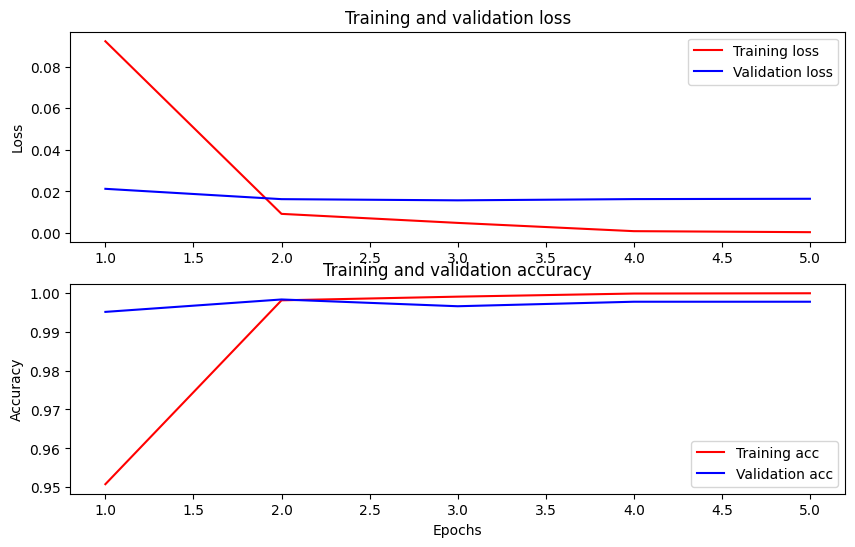

In [ ]:
#PLOT MODEL PERFOMANCE

history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Testing phase

In [ ]:
#EVALUATION
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

306/306 [==============================] - 59s 192ms/step - loss: 0.0163 - binary_accuracy: 0.9971
Loss: 0.016312792897224426
Accuracy: 0.9970549941062927


In [ ]:
# EXAMPLE OF PREDICTION ON SOME OF OUR REVIEWS (ENG)
# A SCORE NEAR 1 STAYS FOR A HUMAN REVIEW
# A SCORE NEAR 0 STAYS FOR A BOT REVIEWS
# THE CLASSIFIER DIDN'T MAKE ANY MISTAKE


def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = ['If you haven\'t already seen this movie of Mary-Kate and Ashley\'s, then all I can say is: "What Are You Waiting For!?". This is yet another terrific and wonderful movie by the fraternal twins that we all know and love so much! It\'s fun, romantic, exciting and absolutely breath-taking (scenery-wise)! Of course; as always, Mary-Kate and Ashley are the main scenery here anyway! Would any true fan want it any other way? Of course not! Anyway; it\'s a great movie in every sense of the word, so if you haven\'t already seen it then you just have to now! I mean right now too! So what are you waiting for? I promise that you won\'t be disappointed! Sincerely, Rick Morris',
           '"Echoes of Autumn" transports viewers to a world of nostalgia and introspection, where the fleeting beauty of the season serves as a poignant metaphor for the passage of time. Directed by the visionary storyteller, Daniel Harper, this cinematic masterpiece weaves a tapestry of longing and remembrance, capturing the essence of a fleeting moment before it fades into memory. Set against the backdrop of a picturesque New England town ablaze with the colors of fall, "Echoes of Autumn" follows the intertwining lives of four strangers brought together by fate on a crisp October afternoon. As they navigate the complexities of love, loss, and redemption, they discover that the bonds of friendship and the promise of new beginnings can emerge even in the twilight of the year. Harper\'s direction is nothing short of poetic, infusing each frame with a sense of melancholic beauty and quiet introspection. The film\'s evocative cinematography, bathed in the warm hues of autumnal sunlight and dappled shadows, evokes a sense of nostalgia and wistful longing for seasons past. The ensemble cast delivers performances of exquisite depth and authenticity, their nuanced portrayals capturing the complexities of human emotion with grace and subtlety. From the luminous Sarah Johnson as the introspective artist grappling with the ghosts of her past to the charming David Chen as the enigmatic stranger who unlocks the secrets of her heart, each character resonates with a sense of universal humanity. In the tapestry of life, "Echoes of Autumn" stands as a reminder of the fleeting nature of time and the enduring power of human connection to transcend the boundaries of season and circumstance. With its poignant storytelling and hauntingly beautiful imagery, this film leaves an indelible mark on the soul, inviting audiences to embrace the beauty of each passing moment before it slips away like leaves in the wind.',
           '“Inception” is a cinematic masterpiece that delves into the depths of the human mind. The plot revolves around a group of thieves who, instead of stealing physical items, infiltrate dreams to extract or implant information. The film is a visual spectacle, with stunning special effects that capture the surreal and often chaotic nature of dreams. The score by Hans Zimmer is equally impressive, providing a haunting backdrop to the film’s intricate narrative. The cast, led by Leonardo DiCaprio and Ellen Page, delivers outstanding performances. DiCaprio, in particular, shines as the troubled protagonist, a skilled extractor named Cobb, who is haunted by his past. “Inception” is also a thought-provoking film, tackling themes such as guilt, loss, and the nature of reality. Despite its complex narrative and high-concept premise, the film manages to explore these universal themes in a deeply moving way. In conclusion, “Inception” is an epic film that combines a gripping plot, spectacular special effects, and memorable performances to create an unforgettable cinematic experience. Despite some narrative complexities that may be challenging to understand, the film is a thrilling journey that is well worth the watch.',
           'I\'d always wanted David Duchovney to go into the movie business, and finally he did, and he made me proud. This movie lived up to what I had hoped for. Duchovney played his character very well, managing to remain consistent with something new, instead of playing the Agent Molder we are used to. Therefore, I give him extra credit for his role, also because I could not see anyone else playing that particular character. David was great, but nothing compared to the psychotic Timothy Hutton. A brilliant performance that you don\'t get tired of throughout the movie, because he never fails to surprise you. He has weaknesses, and strengths, making the story all the more believable. I also very much enjoyed the narration, it added to the story a good deal, and had some very memorable quotes that i still use to all the time. This movie also had a wounderfull score. I recomend this for anyone who likes drama, and doesn\'t mind blood.',
           'Sports watches have been around for a while, and this particular rendition of this sports watch line is worth the purchase or even upgrade.A comfortable wristband starts the process. Add in the ability to load different watch faces (including inserting your own), and you\'re off and running. But as we get into the tools that are available, it\'s an amazing treasure trove of digital tools. Want to check your vitals? This watch checks your numbers with a couple of clicks. It monitors and grades your sleep, counts your steps toward a healthier lifestyle, and can even remotely control music or the camera from your phone. Weather report? Got it. Need a stop watch. A couple of clicks and you\'re there. The screens are laid out so that the geography is large enough to avoid fat fingering and easily readable. Recharging only takes a couple of hours and lasts for days. My favorite part of the whole watch is the flashlight-- it\'s terrific for lighting the way for trips to the fridge or restroom when the rest of the house is asleep. So, you\'re getting a strong versatile watch with lots of tools in its band.',
           'This blender is a fantastic addition to my kitchen. Not only does it have a sleek and modern design that fits perfectly with my decor, but it’s also incredibly functional. The power of the motor is impressive, allowing me to easily blend fruits and vegetables for smoothies, sauces, and soups. The stainless steel blades are sharp and durable, and I’ve noticed they can chop even the hardest ingredients without any problems. Another feature I greatly appreciate is the ease of cleaning. The detachable parts can be washed in the dishwasher, which makes cleaning after use a breeze. In addition, the blender comes with a series of pre-programmed settings that make preparing various dishes even simpler. Whether it’s blending a breakfast smoothie or preparing a sauce for dinner, this blender makes everything easier. In conclusion, I am extremely satisfied with my purchase. This blender has not only improved my kitchen experience, but also elevated the quality of my meals. I would recommend it without hesitation to anyone looking for a high-quality kitchen appliance.',
           'The Grand Budapest Hotel” is a delightful cinematic journey that transports viewers to a bygone era. Set in a fictional European country, the film tells the story of a legendary concierge at a famous hotel and his friendship with a young employee who becomes his trusted protégé. The film is a visual treat, with Anderson’s signature style of vibrant colors, symmetrical shots, and intricate set designs. The cinematography is breathtaking, capturing the grandeur of the hotel and the charm of the surrounding landscapes. The ensemble cast, led by Ralph Fiennes and Tony Revolori, delivers captivating performances. Fiennes, as the charismatic and dedicated concierge, is a standout, bringing a perfect blend of humor and heart to his role. “The Grand Budapest Hotel” is also a film that resonates emotionally, exploring themes of friendship, loyalty, and the passage of time. Despite its whimsical and often comedic tone, the film touches on these themes with a depth and sincerity that is truly moving. In conclusion, “The Grand Budapest Hotel” is a cinematic gem that combines a compelling narrative, stunning visuals, and exceptional performances to create a truly memorable film experience. It’s a charming and poignant tale that is as entertaining as it is thought-provoking, making it a must-watch for any film enthusiast.']

original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the model in memory:
input: If you haven't already seen this movie of Mary-Kate and Ashley's, then all I can say is: "What Are You Waiting For!?". This is yet another terrific and wonderful movie by the fraternal twins that we all know and love so much! It's fun, romantic, exciting and absolutely breath-taking (scenery-wise)! Of course; as always, Mary-Kate and Ashley are the main scenery here anyway! Would any true fan want it any other way? Of course not! Anyway; it's a great movie in every sense of the word, so if you haven't already seen it then you just have to now! I mean right now too! So what are you waiting for? I promise that you won't be disappointed! Sincerely, Rick Morris : score: 0.999999
input: "Echoes of Autumn" transports viewers to a world of nostalgia and introspection, where the fleeting beauty of the season serves as a poignant metaphor for the passage of time. Directed by the visionary storyteller, Daniel Harper, this cinematic masterpiece weaves a ta

In [ ]:
#EXAMPLE OF PREDICTION ON ONE OUR REVIEWS MADE BY A BOT (ITA)
# A SCORE NEAR 1 STAYS FOR A HUMAN REVIEW
# A SCORE NEAR 0 STAYS FOR A BOT REVIEWS
# THE CLASSIFIER MAKE THE WRONG ANSWER

examples = ['“Interstellar” è un’opera maestosa che esplora i confini dell’universo e dell’umanità. La trama ruota attorno a un gruppo di esploratori spaziali che utilizzano un wormhole per superare le limitazioni dei viaggi spaziali umani e conquistare le vaste distanze coinvolte in un viaggio interstellare. Il film è un trionfo visivo, con effetti speciali mozzafiato che catturano l’immensità dello spazio e la bellezza aliena dei mondi lontani. La colonna sonora di Hans Zimmer è altrettanto impressionante, con una musica che risuona perfettamente con l’atmosfera del film. Il cast, guidato da Matthew McConaughey e Anne Hathaway, offre delle performance eccezionali. McConaughey, in particolare, brilla nel ruolo del protagonista, un ingegnere e pilota di nome Cooper, che deve affrontare il dilemma di salvare l’umanità o rimanere con la sua famiglia. “Interstellar” è anche un film che stimola la riflessione, affrontando temi come l’amore, il sacrificio e la sopravvivenza della specie umana. Nonostante la sua ambientazione fantascientifica, il film riesce a toccare questi temi universali in modo profondo e commovente. In conclusione, “Interstellar” è un film epico che combina una trama avvincente, effetti speciali spettacolari e performance memorabili per creare un’esperienza cinematografica indimenticabile. Nonostante alcune complessità scientifiche che possono essere difficili da comprendere, il film è un viaggio emozionante che merita di essere visto.']

original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the model in memory:
input: “Interstellar” è un’opera maestosa che esplora i confini dell’universo e dell’umanità. La trama ruota attorno a un gruppo di esploratori spaziali che utilizzano un wormhole per superare le limitazioni dei viaggi spaziali umani e conquistare le vaste distanze coinvolte in un viaggio interstellare. Il film è un trionfo visivo, con effetti speciali mozzafiato che catturano l’immensità dello spazio e la bellezza aliena dei mondi lontani. La colonna sonora di Hans Zimmer è altrettanto impressionante, con una musica che risuona perfettamente con l’atmosfera del film. Il cast, guidato da Matthew McConaughey e Anne Hathaway, offre delle performance eccezionali. McConaughey, in particolare, brilla nel ruolo del protagonista, un ingegnere e pilota di nome Cooper, che deve affrontare il dilemma di salvare l’umanità o rimanere con la sua famiglia. “Interstellar” è anche un film che stimola la riflessione, affrontando temi come l’amore, il sacrificio e la so